#### Adapted from: "Pattern Recognition and Machine Learning, Christopher M. Bishop" and "A Probabilistic Perspective Murphy 2012"

The goal with variational inference is that given some data (assumed to be gaussian) we want to infer the mean and variance, which also have some underlying distribution.

In this notebook the underlying distribution of the mean and the precision (inverse of variance) is said to be:

#### $p(μ|τ) = \mathcal{N}(\mu|\mu_0,(\kappa_0\tau)^−1)$

#### $p(τ) = Gamma(\tau|a_0, b_0)$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Control the randomness
np.random.seed(0)

Let us generate some data from $\mathcal{N}(x | \mu, \tau)$ by first drawing $\mu$ and $\tau$ from their distributions:

In [2]:
# Our initial parameters for mu and tau
mu_0 = 0
k_0 = 1 # Remember that this is our precision value and not variance.
a_0 = 1
b_0 = 1
N = 15
# Lets generate some data D
tau = np.random.gamma(shape=a_0, scale=b_0, size=1)[0]
mu = np.random.normal(loc=mu_0, scale=1 / (k_0 * tau), size=1)[0]
D = np.random.normal(loc=mu, scale=1 / tau, size=N)
print("𝜇:", mu, ", 𝜏:", tau)
print("mean:", np.mean(D), ", var:", np.var(D))
#print(D)

𝜇: 0.9317948158947394 , 𝜏: 0.79587450816311
mean: 1.6290896120349871 , var: 2.2753896844720845


Remember that the goal now is the approximate distribution over the real posterior $p(\mu, \tau)$, the approximate posterior we're searching for is $q(\mu, \tau) = q_\mu(\mu)q_\tau(\tau)$ where we use the mean field method to factorize these even though the real posterior can not be factorized like this.

From Murphy (chapter 21) and Bishops (chapter 10) book we know that $q_\mu(\mu) = \mathcal{N}(\mu | \mu_N, \kappa_N^-1)$ and that $q_\tau(\tau) = Ga(\tau | a_N, b_N)$

Where:

$\mu_N = \frac{\kappa_0\mu_0 + N\bar{x}}{\kappa_0 + N}$

$\kappa_N = (\kappa_0 + N)\frac{a_N}{b_N}$

$a_N = a_0 + \frac{N + 1}{b_N}$

$b_N = b_0 + \kappa_0(\mathbb{E}[\mu^2] + \mu_0^2 - 2\mathbb{E}[\mu]\mu_0) + \frac{1}{2}\sum_{i=1}^N (x_i^2 + \mathbb{E}[\mu^2] - 2\mathbb{E}[\mu]x_i)$

To ensure that the implementation is correct we can check that the equation (21.98) from Murphy is monotonically increasing (which by definition it should).

In [3]:
def Lq(k_N, a_N, b_N):
    '''
    Equation (21.98) L(q) from Murphy A Probabilistic Perspective
    '''
    from scipy.special import gamma as gamma_func
    return -(1 / 2) * np.log(k_N) + np.log(gamma_func(a_N)) - a_N * np.log(b_N)

Let us save the iterations variables so we can see the approximation every iterations from start to finish

In [4]:
mu_N_save = [mu_0]
k_N_save = [k_0]
a_N_save = [a_0]
b_N_save = [b_0]

In [5]:
mu_N = (k_0 * mu_0 + N * np.mean(D)) / (k_0 + N)
mu_N_save.append(mu_N)
a_N = a_0 + (N + 1) / 2
a_N_save.append(a_N)
emu = mu_N
changed = 0
k_N = 1
iterations = 0
last_Lq = -1
while True:
    iterations += 1
    emu2 = (1 / k_N) + np.power(mu_N, 2)
    last_sum = 0
    for i in range(N):
        last_sum += np.power(D[i], 2) + emu2 - 2 * emu * D[i]
    b_N = b_0 + k_0 * (emu2 + np.power(mu_0, 2) - 2 * emu * mu_0) + (1 / 2) * last_sum
    b_N_save.append(b_N)
    k_N = (k_0 + N)*(a_N / b_N)
    k_N_save.append(k_N)
        
    # Sanity check
    current_Lq = Lq(k_N, a_N, b_N)
    if abs(current_Lq - last_Lq) < 10**-6:
        print("Done! Found local minimum after ", iterations, " iterations.")
        break
    last_Lq = current_Lq

Done! Found local minimum after  8  iterations.


In [6]:
print("mu_N:", mu_N, "\nk_N:", k_N, "\na_N:", a_N, "\nb_N:", b_N)

mu_N: 1.5272715112828004 
k_N: 6.617589754339474 
a_N: 9.0 
b_N: 21.76018842896271


To visualize the approximate posterior $q(\mu, \tau)$ we can loop over values for $\mu$ and $\tau$ calculate the probability for that value, this will give us a contour plot over $q(\mu, \tau)$.

In [12]:
def gamma_pdf(shape, rate):
    from scipy.special import gamma
    def pdf(x):
        return np.power(rate, shape) / gamma(shape) * np.power(x, shape - 1) * np.exp(-rate * x)
    return pdf

def normal_pdf(loc, precision):
    from scipy.stats import norm
    def pdf(x):
        return norm.pdf(x, loc, 1 / precision)
    return pdf

def approx_q(mu, tau, n_pdf, g_pdf):
    return n_pdf(mu) * g_pdf(tau)

In [8]:
number_grid_points = 50
X, Y = np.meshgrid(np.linspace(.5, 2.5, number_grid_points), np.linspace(0, 1.5, number_grid_points))
g_pdf = gamma_pdf(a_N, b_N)
n_pdf = normal_pdf(mu_N, k_N)
Z = approx_q(X, Y, n_pdf, g_pdf)

Text(0, 0.5, 'tau')

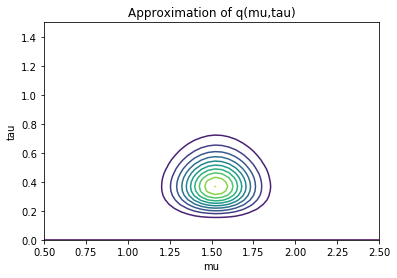

In [9]:
plt.contour(X, Y, Z, levels=10)
plt.title("Approximation of q(mu,tau)")
plt.xlabel("mu")
plt.ylabel("tau")

Let us save the approximation for each iteration saved, and save an image for each


In [11]:
number_grid_points = 50
X, Y = np.meshgrid(np.linspace(.5, 2.5, number_grid_points), np.linspace(0, 1.5, number_grid_points))
for i in range(iterations):
    ei = i if i <= 1 else 1
    g_pdf = gamma_pdf(a_N_save[ei], b_N_save[i])
    n_pdf = normal_pdf(mu_N_save[ei], k_N_save[i])
    Z = approx_q(X, Y, n_pdf, g_pdf)

    plt.contour(X, Y, Z, levels=10)
    plt.title("Approximation of q(mu,tau), iteration=" + str(i))
    plt.xlabel("mu")
    plt.ylabel("tau")
    plt.savefig("approx_q_" + str(i))
    plt.close()

# TODO HERE ON AND DOWN

Let us visualize the exact posterior of $p(\mu, \tau)$

Following the implementation of Bishops book equation (2.154), chapter 2.3.6. Where the exact distribution is:

$p(\mu, \tau) = \mathcal{N}(\mu | \mu_0, (\beta\tau)^{-1})Gam(\tau, a, b)$

In [55]:
def exact_posterior(mu, tau, mu_0, beta, a, b):
    from scipy.stats import norm
    from scipy.special import gamma
    gamma_pdf = np.power(b, a) / gamma(a) * np.power(tau, a - 1) * np.exp(-b * tau)
    return norm.pdf(mu, mu_0, 1 / (beta * tau)) * gamma_pdf

Comparing with Figure 2.14 in Bishops book where the values of 0, 2, 5 and 6 is used respectivly for $\mu_0$, $beta$, $a$ and $b$.

c:\python36\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


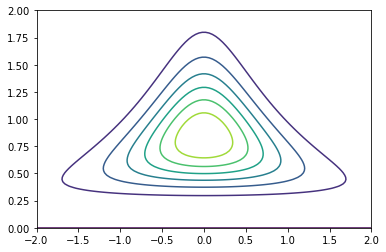

In [57]:
number_grid_points = 100
X, Y = np.meshgrid(np.linspace(-2, 2, number_grid_points), np.linspace(0, 2, number_grid_points))
Z = exact_posterior(X, Y, 0, 2, 5, 6)
plt.contour(X, Y, Z, levels=7)

Let us visualize the exact posterior for our example:

c:\python36\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


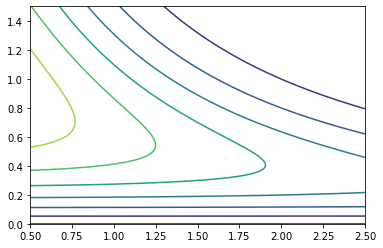

In [61]:
number_grid_points = 100
X, Y = np.meshgrid(np.linspace(.5, 2.5, number_grid_points), np.linspace(0, 1.5, number_grid_points))
Z = exact_posterior(X, Y, mu_0, k_0, a_0, b_0)
plt.contour(X, Y, Z, levels=7)